In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import optuna
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from features
recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

def prepare_exogenous_features(train_df, test_df, target_indicator):
    """Prepare exogenous features for Prophet from train and test dataframes"""
    print(f"\nPreparing exogenous features for {target_indicator}...")
    
    # Define features to exclude (date, target, and recession targets)
    features_to_exclude = ['date'] + recession_targets + [target_indicator]
    
    # Get available features from training data
    available_features = [c for c in train_df.columns if c not in features_to_exclude]
    
    print(f"Available exogenous features: {len(available_features)}")
    print(f"Features: {available_features[:10]}..." if len(available_features) > 10 else f"Features: {available_features}")
    
    # Ensure test data has the same features
    common_features = [f for f in available_features if f in test_df.columns]
    
    if len(common_features) != len(available_features):
        missing_in_test = set(available_features) - set(common_features)
        print(f"Warning: {len(missing_in_test)} features missing in test data: {missing_in_test}")
    
    return common_features

def clean_prophet_data(train_df, test_df, target_indicator, exog_features):
    """Clean and prepare data for Prophet format"""
    print(f"Cleaning Prophet data for {target_indicator}...")
    
    # Create Prophet-format dataframes
    train_prophet = pd.DataFrame({
        'ds': pd.to_datetime(train_df['date']),
        'y': train_df[target_indicator]
    })
    
    test_prophet = pd.DataFrame({
        'ds': pd.to_datetime(test_df['date']),
        'y': test_df[target_indicator]
    })
    
    # Add exogenous features to both train and test
    for feature in exog_features:
        if feature in train_df.columns and feature in test_df.columns:
            # Clean feature data
            train_feature = train_df[feature].replace([np.inf, -np.inf], np.nan)
            test_feature = test_df[feature].replace([np.inf, -np.inf], np.nan)
            
            # Forward fill, backward fill, then use median
            train_feature = train_feature.fillna(method='ffill').fillna(method='bfill')
            test_feature = test_feature.fillna(method='ffill').fillna(method='bfill')
            
            # Use training median for any remaining NaNs
            train_median = train_feature.median()
            train_feature = train_feature.fillna(train_median)
            test_feature = test_feature.fillna(train_median)
            
            # Final fallback to 0
            train_feature = train_feature.fillna(0)
            test_feature = test_feature.fillna(0)
            
            # Add to Prophet dataframes
            train_prophet[feature] = train_feature.values
            test_prophet[feature] = test_feature.values
    
    # Remove rows with NaN target values
    train_prophet = train_prophet.dropna(subset=['y'])
    test_prophet = test_prophet.dropna(subset=['y'])
    
    # Remove features with no variation in training data
    varying_features = []
    for feature in exog_features:
        if feature in train_prophet.columns and train_prophet[feature].nunique() > 1:
            varying_features.append(feature)
        elif feature in train_prophet.columns:
            train_prophet = train_prophet.drop(columns=[feature])
            if feature in test_prophet.columns:
                test_prophet = test_prophet.drop(columns=[feature])
    
    print(f"  Train shape: {train_prophet.shape}, Test shape: {test_prophet.shape}")
    print(f"  Features with variation: {len(varying_features)}")
    print(f"  Remaining missing values - Train: {train_prophet.isnull().sum().sum()}, Test: {test_prophet.isnull().sum().sum()}")
    
    return train_prophet, test_prophet, varying_features

def make_prophet_objective(train_data, test_data, exog_features):
    """Create Optuna objective function for Prophet hyperparameter tuning"""
    def objective(trial):
        # Prophet parameters to tune
        params = {
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
            'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
            'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, False, 'auto']),
            'weekly_seasonality': trial.suggest_categorical('weekly_seasonality', [True, False, 'auto']),
            'daily_seasonality': False,  # Usually False for financial data
        }
        
        try:
            # Create and fit model
            model = Prophet(
                interval_width=0.95,
                **params
            )
            
            # Add exogenous regressors
            for feature in exog_features:
                if feature in train_data.columns:
                    model.add_regressor(feature)
            
            # Fit model
            model.fit(train_data)
            
            # Create future dataframe for validation (use part of training data)
            val_size = min(20, len(test_data))  # Use smaller validation set
            val_data = train_data.tail(val_size).copy()
            
            # Make prediction
            forecast = model.predict(val_data)
            
            # Calculate RMSE
            y_true = val_data['y'].values
            y_pred = forecast['yhat'].values
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            return rmse
            
        except Exception as e:
            print(f"Trial failed: {e}")
            return float('inf')
    
    return objective

def forecast_indicator_with_prophet(train_df, test_df, indicator, n_trials=30):
    """Forecast indicator using Prophet with exogenous features"""
    print(f"\n{'='*60}\nFORECASTING: {indicator}\n{'='*60}")
    
    if indicator not in train_df.columns or indicator not in test_df.columns:
        print(f"ERROR: {indicator} not in datasets")
        return None
    
    # Check data availability
    train_series = train_df[indicator].dropna()
    test_series = test_df[indicator].dropna()
    print(f"Series lengths - Train: {len(train_series)}, Test: {len(test_series)}")
    
    if len(train_series) < 20:  # Prophet needs more data points
        print(f"ERROR: Insufficient training data for {indicator} (need at least 20 points)")
        return None
    
    # Prepare exogenous features
    try:
        exog_features = prepare_exogenous_features(train_df, test_df, indicator)
        train_prophet, test_prophet, varying_features = clean_prophet_data(
            train_df, test_df, indicator, exog_features
        )
        
        if len(varying_features) == 0:
            print(f"WARNING: No exogenous features available for {indicator}")
            varying_features = []  # Continue without exogenous features
            
    except Exception as e:
        print(f"ERROR preparing features: {e}")
        return None
    
    if len(train_prophet) < 20:
        print(f"ERROR: Insufficient clean training data for {indicator}: {len(train_prophet)} rows")
        return None
    
    print(f"Clean data shapes - Train: {train_prophet.shape}, Test: {test_prophet.shape}")
    print(f"Using {len(varying_features)} exogenous features: {varying_features[:5]}{'...' if len(varying_features) > 5 else ''}")
    
    # Hyperparameter tuning with Optuna
    print(f"\nRunning Prophet hyperparameter optimization...")
    
    try:
        study = optuna.create_study(direction="minimize")
        study.optimize(
            make_prophet_objective(train_prophet, test_prophet, varying_features),
            n_trials=n_trials,
            show_progress_bar=False
        )
        
        best_params = study.best_params
        print(f"Best parameters: {best_params}")
        print(f"Best validation RMSE: {study.best_value:.4f}")
        
        # Train final model with best parameters
        final_model = Prophet(
            interval_width=0.95,
            **best_params
        )
        
        # Add exogenous regressors
        for feature in varying_features:
            if feature in train_prophet.columns:
                final_model.add_regressor(feature)
        
        # Fit final model
        print("Training final Prophet model...")
        final_model.fit(train_prophet)
        
        # Create future dataframe for forecasting
        future_df = test_prophet[['ds'] + varying_features].copy()
        
        # Make forecast
        forecast = final_model.predict(future_df)
        
        # Extract predictions and actual values
        y_pred = forecast['yhat'].values
        y_true = test_prophet['y'].values
        
        # Calculate metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # Calculate MAPE
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.inf
        
        print(f"\nAccuracy Metrics:\n  MAE: {mae:.4f}\n  RMSE: {rmse:.4f}\n  MAPE: {mape:.2f}%")
        
        # Save model
        os.makedirs("prophet_models", exist_ok=True)
        with open(f"prophet_models/{indicator}_prophet_model.pkl", "wb") as f:
            pickle.dump(final_model, f)
        print(f"Model saved to prophet_models/{indicator}_prophet_model.pkl")
        
        return {
            'model': final_model,
            'best_params': best_params,
            'best_val_rmse': study.best_value,
            'forecast': y_pred,
            'actual': y_true,
            'forecast_df': forecast,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'exog_features': varying_features,
            'train_length': len(train_prophet),
            'test_length': len(test_prophet),
            'train_dates': train_prophet['ds'].values,
            'test_dates': test_prophet['ds'].values
        }
        
    except Exception as e:
        print(f"ERROR training Prophet for {indicator}: {e}")
        return None

def plot_prophet_forecast_results(results, indicator):
    """Plot Prophet forecast results"""
    if results is None:
        return
        
    plt.figure(figsize=(15, 8))
    
    # Plot training data (last portion for visibility)
    train_dates = results['train_dates']
    train_plot_size = min(50, len(train_dates))
    train_dates_plot = train_dates[-train_plot_size:]
    
    # We don't have train target values in results, so we'll focus on test data
    test_dates = results['test_dates']
    actual = results['actual']
    forecast = results['forecast']
    forecast_df = results['forecast_df']
    
    # Plot actual vs forecast
    plt.plot(test_dates, actual, label='Actual', color='green', linewidth=2, marker='o', markersize=4)
    plt.plot(test_dates, forecast, label='Forecast', color='red', linewidth=2, marker='s', markersize=4)
    
    # Plot confidence intervals if available
    if 'yhat_lower' in forecast_df.columns and 'yhat_upper' in forecast_df.columns:
        plt.fill_between(test_dates, 
                        forecast_df['yhat_lower'].values, 
                        forecast_df['yhat_upper'].values, 
                        alpha=0.3, color='red', label='Confidence Interval')
    
    # Add title with metrics
    plt.title(f'{indicator} - Prophet Forecast\n'
              f'MAE: {results["mae"]:.4f}, RMSE: {results["rmse"]:.4f}, MAPE: {results["mape"]:.2f}%\n'
              f'Features used: {len(results["exog_features"])}',
              fontsize=14)
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def run_prophet_forecasting_with_exogenous(train_df, test_df, financial_indicators=None, n_trials=30, plot_results=True):
    """Run Prophet forecasting pipeline with exogenous features"""
    print("=" * 80)
    print("PROPHET TIME SERIES FORECASTING - WITH EXOGENOUS FEATURES")
    print("=" * 80)
    
    if financial_indicators is None:
        financial_indicators = [
            '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
            '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
            'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
        ]
    
    train_work = train_df.copy()
    test_work = test_df.copy()
    
    # Check available indicators
    available = [i for i in financial_indicators if i in train_work.columns and i in test_work.columns]
    print(f"Indicators to forecast: {available}")
    print(f"Excluding recession features: {recession_targets}")
    
    all_results = {}
    forecasted = pd.DataFrame({'date': pd.to_datetime(test_work['date'])})
    
    for ind in available:
        res = forecast_indicator_with_prophet(
            train_work, test_work, ind, 
            n_trials=n_trials
        )
        
        if res:
            all_results[ind] = res
            
            # Add results to forecasted dataframe
            forecasted[f'{ind}_forecast'] = np.nan
            forecasted[f'{ind}_actual'] = np.nan
            
            # Align forecasts with dates
            test_dates = pd.to_datetime(res['test_dates'])
            for i, date in enumerate(test_dates):
                mask = forecasted['date'] == date
                if mask.any():
                    idx = forecasted[mask].index[0]
                    if i < len(res['forecast']):
                        forecasted.loc[idx, f'{ind}_forecast'] = res['forecast'][i]
                        forecasted.loc[idx, f'{ind}_actual'] = res['actual'][i]
            
            if plot_results:
                plot_prophet_forecast_results(res, ind)
    
    print(f"\n{'='*60}")
    print("PROPHET FORECASTING COMPLETE")
    print(f"{'='*60}")
    print(f"Successfully forecasted {len(all_results)} indicators")
    
    # Print summary metrics
    if all_results:
        print(f"\nSUMMARY METRICS:")
        for ind, res in all_results.items():
            print(f"{ind:20s} - MAE: {res['mae']:.4f}, RMSE: {res['rmse']:.4f}, MAPE: {res['mape']:.2f}% (Features: {len(res['exog_features'])})")
    
    return all_results, forecasted

def prophet_quick_forecast(train_df, test_df, indicator, exog_features=None):
    """Quick Prophet forecast with default parameters for testing"""
    print(f"\nQuick Prophet forecast for {indicator}...")
    
    # Prepare data
    train_prophet = pd.DataFrame({
        'ds': pd.to_datetime(train_df['date']),
        'y': train_df[indicator]
    }).dropna()
    
    test_prophet = pd.DataFrame({
        'ds': pd.to_datetime(test_df['date']),
        'y': test_df[indicator]
    }).dropna()
    
    # Add exogenous features if specified
    if exog_features:
        for feature in exog_features:
            if feature in train_df.columns and feature in test_df.columns:
                train_prophet[feature] = train_df[feature].fillna(method='ffill').fillna(0)
                test_prophet[feature] = test_df[feature].fillna(method='ffill').fillna(0)
    
    # Create and fit model
    model = Prophet()
    
    # Add regressors
    if exog_features:
        for feature in exog_features:
            if feature in train_prophet.columns:
                model.add_regressor(feature)
    
    model.fit(train_prophet)
    
    # Forecast
    future_df = test_prophet[['ds'] + (exog_features or [])].copy()
    forecast = model.predict(future_df)
    
    # Calculate metrics
    y_true = test_prophet['y'].values
    y_pred = forecast['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"Quick forecast - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    
    return model, forecast, y_true, y_pred

In [2]:
train_df = pd.read_csv('../../data/fix/feature_selected_recession_train.csv')
test_df = pd.read_csv('../../data/fix/feature_selected_recession_test.csv')

[I 2025-10-01 19:30:21,728] A new study created in memory with name: no-name-0713ed03-9381-4d51-b220-46acdd2c581d


PROPHET TIME SERIES FORECASTING - WITH EXOGENOUS FEATURES
Indicators to forecast: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index', 'gdp_per_capita']
Excluding recession features: ['recession_probability', '1_month_recession_probability', '3_month_recession_probability', '6_month_recession_probability']

FORECASTING: 1_year_rate
Series lengths - Train: 556, Test: 65

Preparing exogenous features for 1_year_rate...
Available exogenous features: 29
Features: ['3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 1_year_rate...
  Train shape: (556, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (556, 31), Test: (65, 31)
Using 29 exogenous features: ['3_months_rate', '6_months_rate', 'CPI'

19:30:22 - cmdstanpy - INFO - Chain [1] start processing
19:30:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:30:23,387] Trial 0 finished with value: 1.6002880263751083 and parameters: {'changepoint_prior_scale': 0.0013861880166412446, 'seasonality_prior_scale': 0.02766398990141867, 'holidays_prior_scale': 0.14946275619900598, 'seasonality_mode': 'additive', 'changepoint_range': 0.9012209608200215, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 1.6002880263751083.
19:30:23 - cmdstanpy - INFO - Chain [1] start processing
19:30:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:30:24,906] Trial 1 finished with value: 0.01888337392095197 and parameters: {'changepoint_prior_scale': 0.2556788836355844, 'seasonality_prior_scale': 6.2046572327552845, 'holidays_prior_scale': 0.053772063303532645, 'seasonality_mode': 'additive', 'changepoint_range': 0.8727554901443535, 'yearly_seasonality': False, 'weekly_seasonality'

Best parameters: {'changepoint_prior_scale': 0.003359174058664876, 'seasonality_prior_scale': 0.4819870731255719, 'holidays_prior_scale': 0.2502756564433931, 'seasonality_mode': 'additive', 'changepoint_range': 0.9156877683235344, 'yearly_seasonality': False, 'weekly_seasonality': True}
Best validation RMSE: 0.0155
Training final Prophet model...


19:30:53 - cmdstanpy - INFO - Chain [1] start processing
19:30:54 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 0.1777
  RMSE: 0.2066
  MAPE: 22.54%
Model saved to prophet_models/1_year_rate_prophet_model.pkl


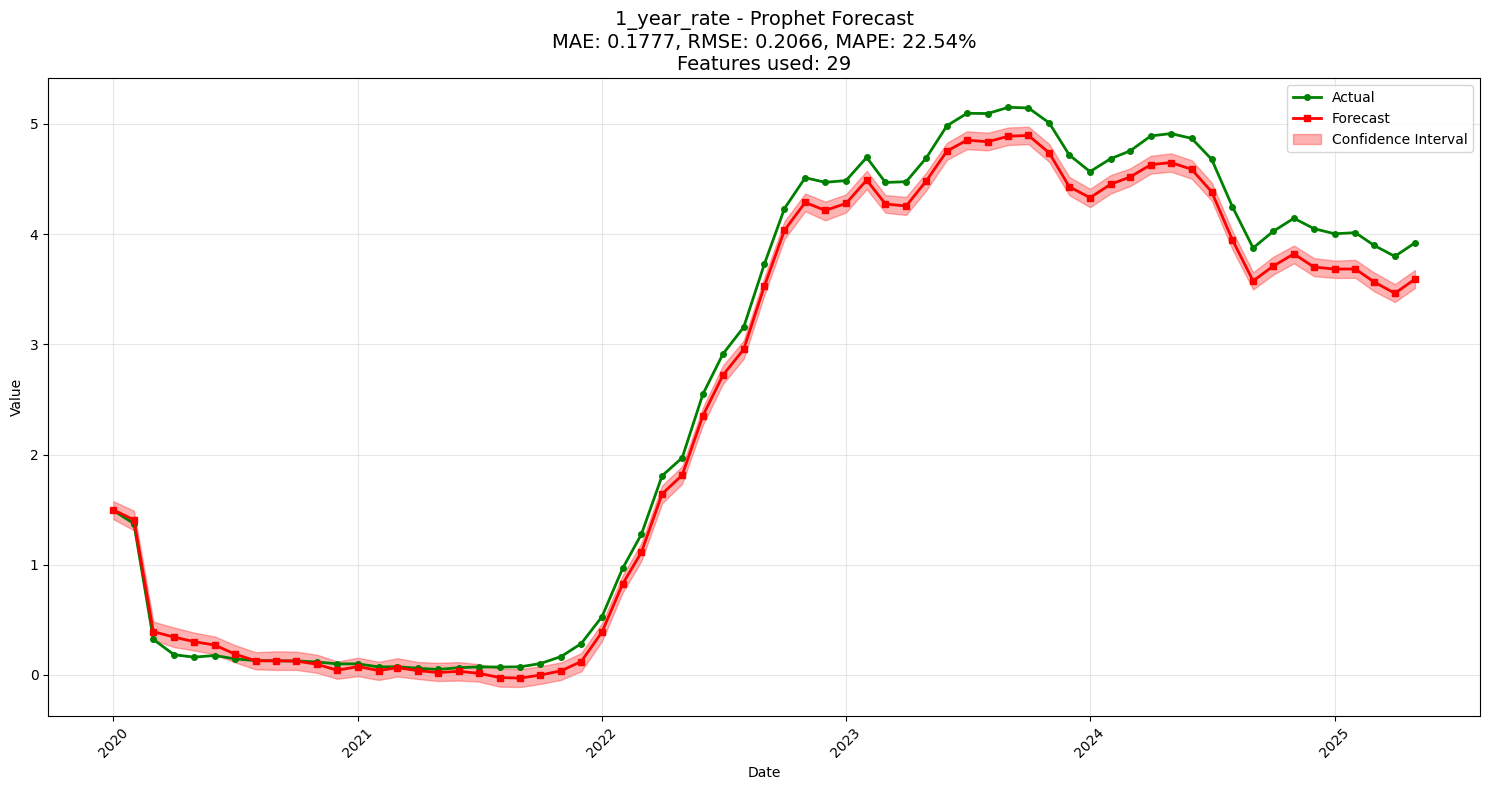

[I 2025-10-01 19:30:55,190] A new study created in memory with name: no-name-45f4404f-2ceb-4975-8c52-b1a59c7dc7c8



FORECASTING: 3_months_rate
Series lengths - Train: 635, Test: 65

Preparing exogenous features for 3_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 3_months_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate']...

Running Prophet hyperparameter optimization...


19:30:55 - cmdstanpy - INFO - Chain [1] start processing
19:30:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:30:56,793] Trial 0 finished with value: 0.03698064545572551 and parameters: {'changepoint_prior_scale': 0.029679447216702414, 'seasonality_prior_scale': 0.3198301738948378, 'holidays_prior_scale': 0.0683754455590161, 'seasonality_mode': 'additive', 'changepoint_range': 0.8537535887990543, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.03698064545572551.
19:30:57 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:30:59,069] Trial 1 finished with value: 0.0376495095923381 and parameters: {'changepoint_prior_scale': 0.4583743565104144, 'seasonality_prior_scale': 0.10013042338302555, 'holidays_prior_scale': 2.413244029845869, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8908889534028709, 'yearly_seasonality': 'auto', 'weekly_seasonality

Best parameters: {'changepoint_prior_scale': 0.007950986955006784, 'seasonality_prior_scale': 5.687983423062686, 'holidays_prior_scale': 1.1671503535076808, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8445768689966363, 'yearly_seasonality': False, 'weekly_seasonality': False}
Best validation RMSE: 0.0119
Training final Prophet model...


19:31:27 - cmdstanpy - INFO - Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 0.2478
  RMSE: 0.2689
  MAPE: 105.22%
Model saved to prophet_models/3_months_rate_prophet_model.pkl


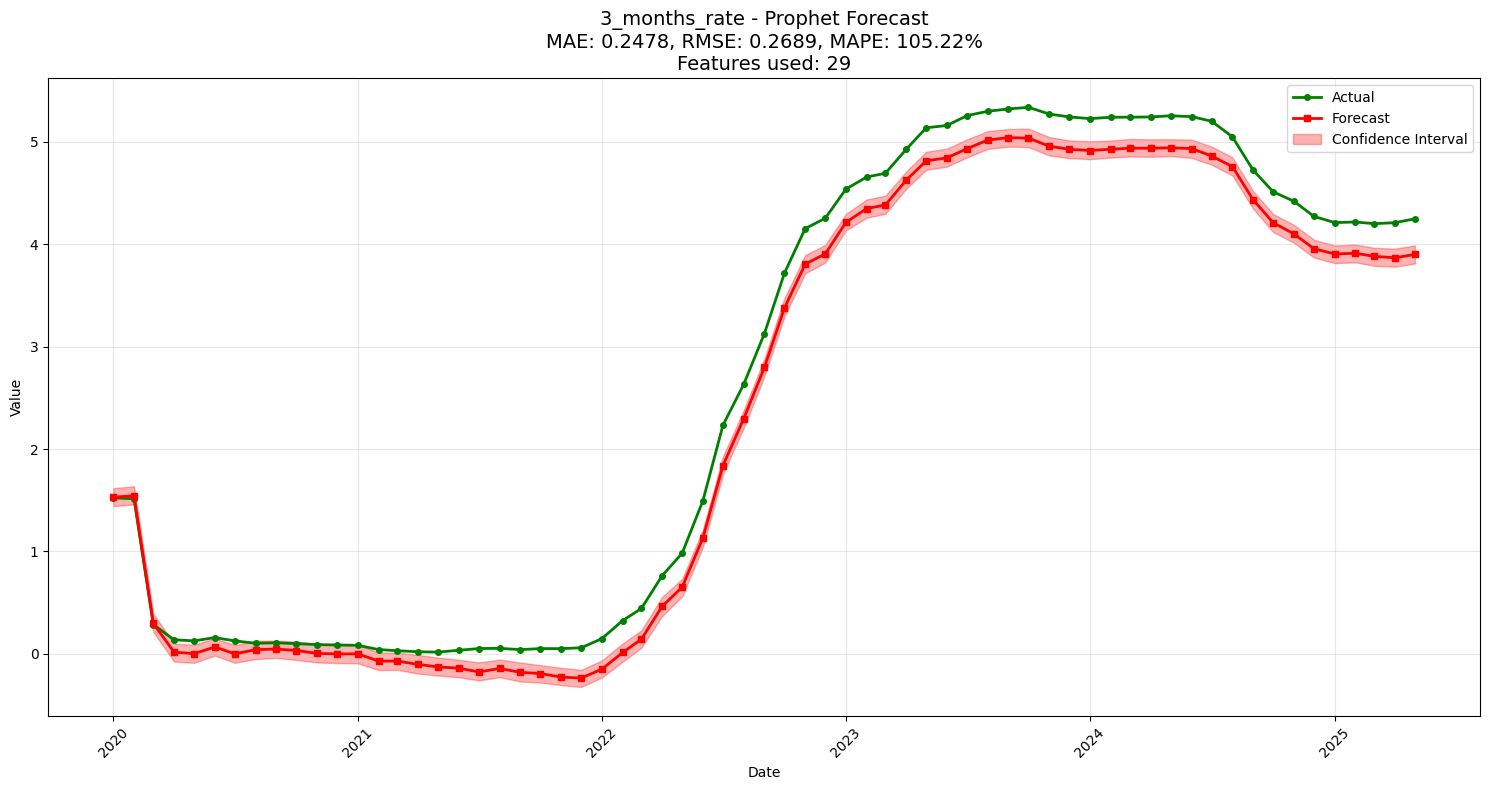


FORECASTING: 6_months_rate
Series lengths - Train: 635, Test: 65

Preparing exogenous features for 6_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 6_months_rate...


[I 2025-10-01 19:31:28,460] A new study created in memory with name: no-name-a0d74931-94d8-4527-a555-48bd9fa2edba


  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', 'CPI', 'INDPRO', '10_year_rate']...

Running Prophet hyperparameter optimization...


19:31:28 - cmdstanpy - INFO - Chain [1] start processing
19:31:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:31:30,095] Trial 0 finished with value: 0.029640676619589967 and parameters: {'changepoint_prior_scale': 0.005137134871640731, 'seasonality_prior_scale': 0.24007671362579733, 'holidays_prior_scale': 0.07343572690882053, 'seasonality_mode': 'additive', 'changepoint_range': 0.8337394314312166, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.029640676619589967.
19:31:30 - cmdstanpy - INFO - Chain [1] start processing
19:31:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:31:30,948] Trial 1 finished with value: 0.028130097136501046 and parameters: {'changepoint_prior_scale': 0.004859896296279857, 'seasonality_prior_scale': 4.16317097815108, 'holidays_prior_scale': 0.296243405245781, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8507640323942985, 'yearly_seasonality': 'auto', 'weekly_seas

Best parameters: {'changepoint_prior_scale': 0.0010534302449382194, 'seasonality_prior_scale': 1.3001510303060169, 'holidays_prior_scale': 1.3779494930230993, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8965178428442167, 'yearly_seasonality': False, 'weekly_seasonality': False}
Best validation RMSE: 0.0090
Training final Prophet model...


19:31:55 - cmdstanpy - INFO - Chain [1] start processing
19:31:55 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 0.0961
  RMSE: 0.1102
  MAPE: 30.80%
Model saved to prophet_models/6_months_rate_prophet_model.pkl


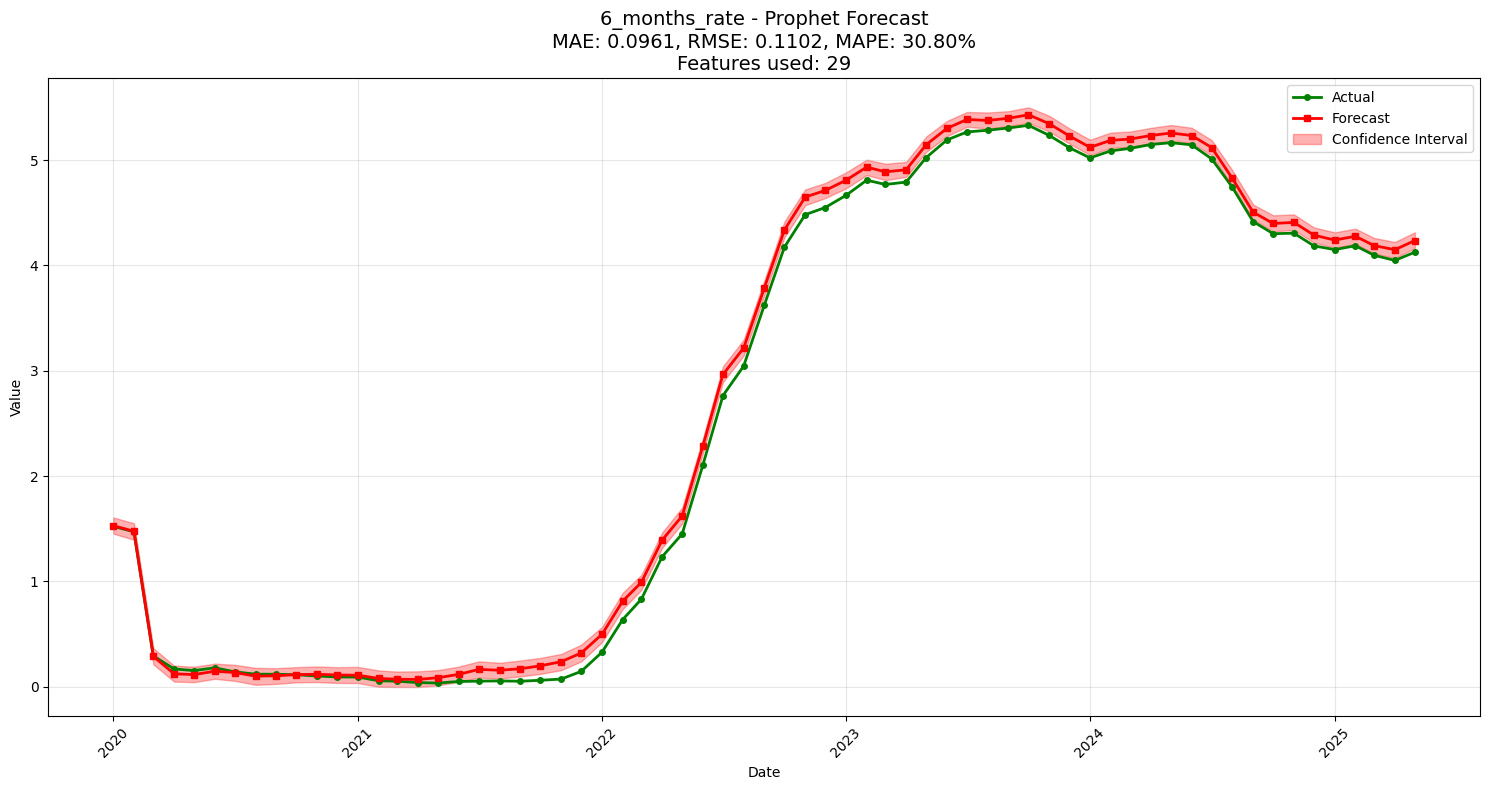

[I 2025-10-01 19:31:55,896] A new study created in memory with name: no-name-cb455180-8a84-4892-83da-7f89cb357388



FORECASTING: CPI
Series lengths - Train: 635, Test: 65

Preparing exogenous features for CPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for CPI...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'INDPRO', '10_year_rate']...

Running Prophet hyperparameter optimization...


19:31:56 - cmdstanpy - INFO - Chain [1] start processing
19:31:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:31:57,516] Trial 0 finished with value: 0.4200625066814677 and parameters: {'changepoint_prior_scale': 0.3137882516833577, 'seasonality_prior_scale': 0.21667566392945983, 'holidays_prior_scale': 0.9735725115129089, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8062418675890682, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.4200625066814677.
19:31:57 - cmdstanpy - INFO - Chain [1] start processing
19:31:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:31:58,598] Trial 1 finished with value: 0.4283212990169424 and parameters: {'changepoint_prior_scale': 0.005485885700254321, 'seasonality_prior_scale': 1.392875505151122, 'holidays_prior_scale': 2.2298843426724297, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8440197229057378, 'yearly_seasonality': 'auto', 'weekly_seasona

Best parameters: {'changepoint_prior_scale': 0.277597746027983, 'seasonality_prior_scale': 0.09782983322518143, 'holidays_prior_scale': 2.46446442081096, 'seasonality_mode': 'additive', 'changepoint_range': 0.8718514379462577, 'yearly_seasonality': False, 'weekly_seasonality': True}
Best validation RMSE: 0.3733
Training final Prophet model...


19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:48 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 27.2472
  RMSE: 33.8022
  MAPE: 8.91%
Model saved to prophet_models/CPI_prophet_model.pkl


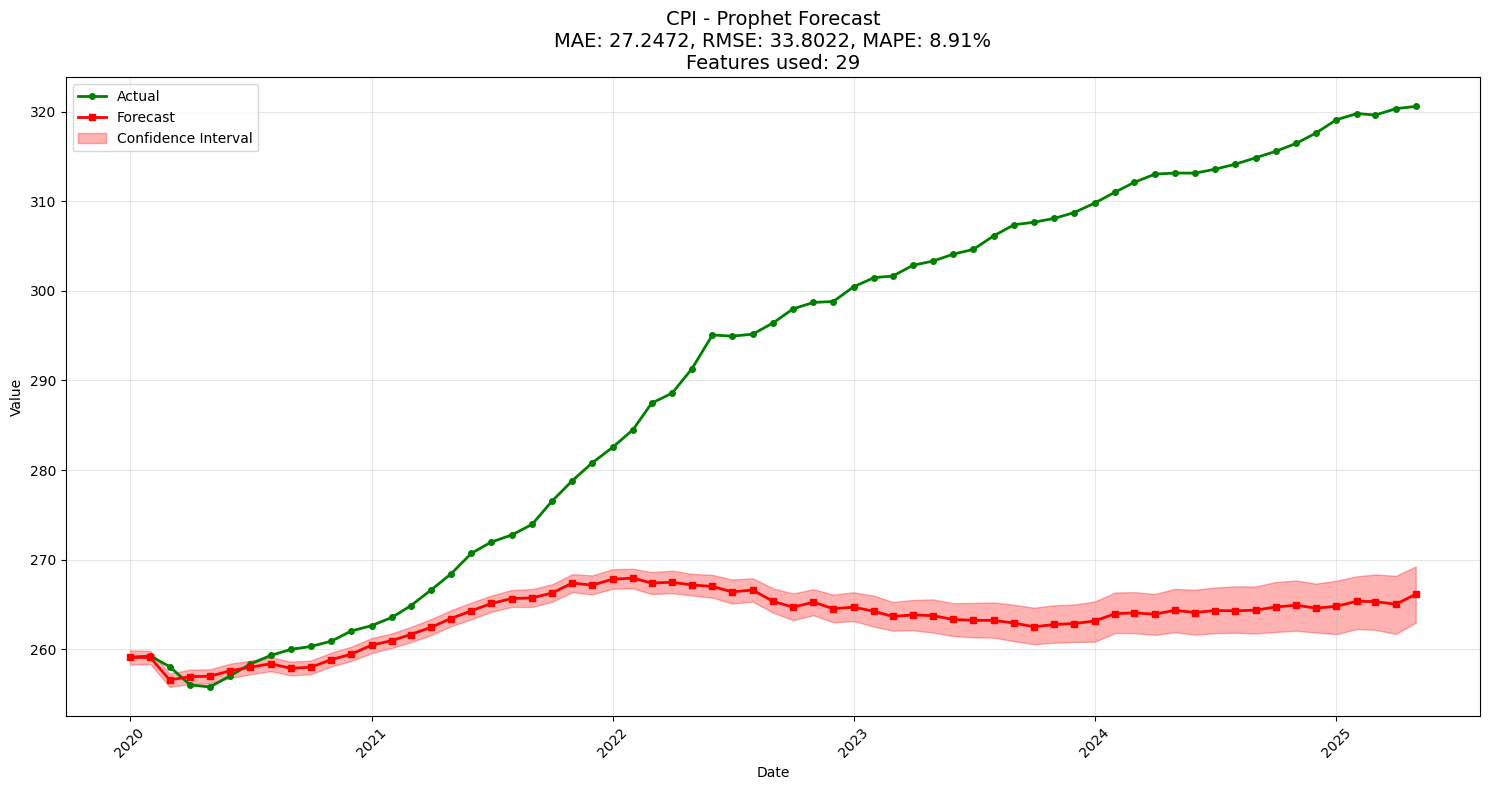


FORECASTING: INDPRO
Series lengths - Train: 635, Test: 65

Preparing exogenous features for INDPRO...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for INDPRO...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', '10_year_rate']...

Running Prophet hyperparameter optimization...


[I 2025-10-01 19:32:48,877] A new study created in memory with name: no-name-67f550d6-9408-4a7c-9729-c4335dde136b
19:32:49 - cmdstanpy - INFO - Chain [1] start processing
19:32:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:32:49,799] Trial 0 finished with value: 0.41670535330455033 and parameters: {'changepoint_prior_scale': 0.007649389933545252, 'seasonality_prior_scale': 0.09853548990779698, 'holidays_prior_scale': 1.2068798645094962, 'seasonality_mode': 'additive', 'changepoint_range': 0.9342960045922672, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 0 with value: 0.41670535330455033.
19:32:50 - cmdstanpy - INFO - Chain [1] start processing
19:32:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:32:50,902] Trial 1 finished with value: 0.424270816973496 and parameters: {'changepoint_prior_scale': 0.4125842423993519, 'seasonality_prior_scale': 0.9865113140047074, 'holidays_prior_scale': 0.029161492585334684, 'seasonality

Best parameters: {'changepoint_prior_scale': 0.23740032011967013, 'seasonality_prior_scale': 1.3075574823652307, 'holidays_prior_scale': 0.28653964264201753, 'seasonality_mode': 'additive', 'changepoint_range': 0.8144485205476262, 'yearly_seasonality': True, 'weekly_seasonality': True}
Best validation RMSE: 0.3872
Training final Prophet model...


19:33:32 - cmdstanpy - INFO - Chain [1] start processing
19:33:33 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 6.0030
  RMSE: 6.6032
  MAPE: 5.88%
Model saved to prophet_models/INDPRO_prophet_model.pkl


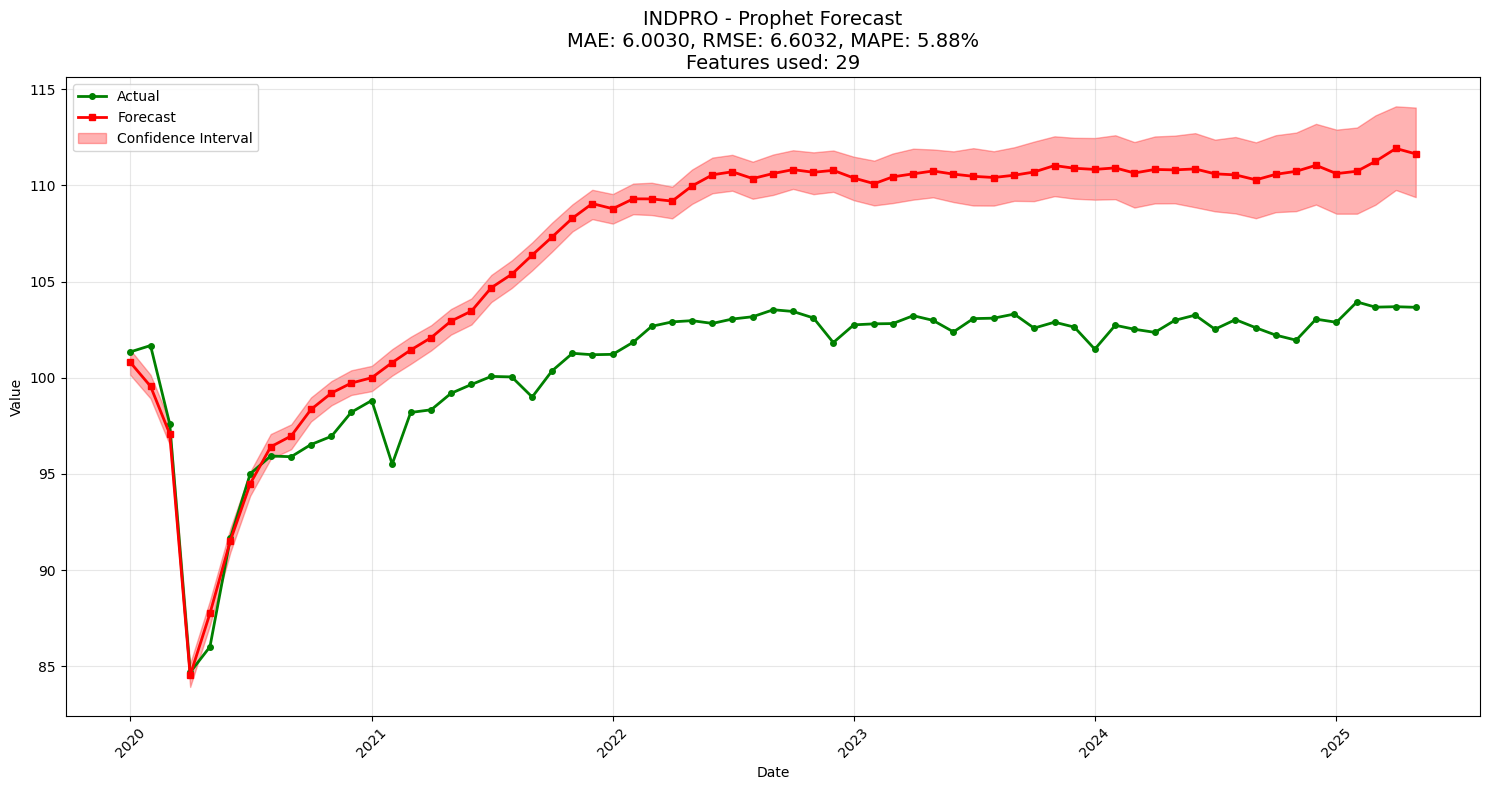

[I 2025-10-01 19:33:34,217] A new study created in memory with name: no-name-3f5656dc-c9e7-4a46-b08a-ec9b674ef812



FORECASTING: 10_year_rate
Series lengths - Train: 635, Test: 65

Preparing exogenous features for 10_year_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 10_year_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


19:33:34 - cmdstanpy - INFO - Chain [1] start processing
19:33:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:33:35,117] Trial 0 finished with value: 0.09527925104559412 and parameters: {'changepoint_prior_scale': 0.011325785535958904, 'seasonality_prior_scale': 5.433339764139157, 'holidays_prior_scale': 6.389826328716328, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.860289832826892, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 0 with value: 0.09527925104559412.
19:33:35 - cmdstanpy - INFO - Chain [1] start processing
19:33:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:33:36,274] Trial 1 finished with value: 0.10667813949644617 and parameters: {'changepoint_prior_scale': 0.2884340309828484, 'seasonality_prior_scale': 0.04695088697961908, 'holidays_prior_scale': 0.01898404618092756, 'seasonality_mode': 'additive', 'changepoint_range': 0.8532320623205969, 'yearly_seasonality': True, 'weekly_seasonality': '

Best parameters: {'changepoint_prior_scale': 0.0043505402325176076, 'seasonality_prior_scale': 1.191726043264777, 'holidays_prior_scale': 1.8457039978483147, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8753789037377507, 'yearly_seasonality': False, 'weekly_seasonality': False}
Best validation RMSE: 0.0729
Training final Prophet model...


19:33:57 - cmdstanpy - INFO - Chain [1] start processing
19:33:57 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 0.1731
  RMSE: 0.1970
  MAPE: 6.81%
Model saved to prophet_models/10_year_rate_prophet_model.pkl


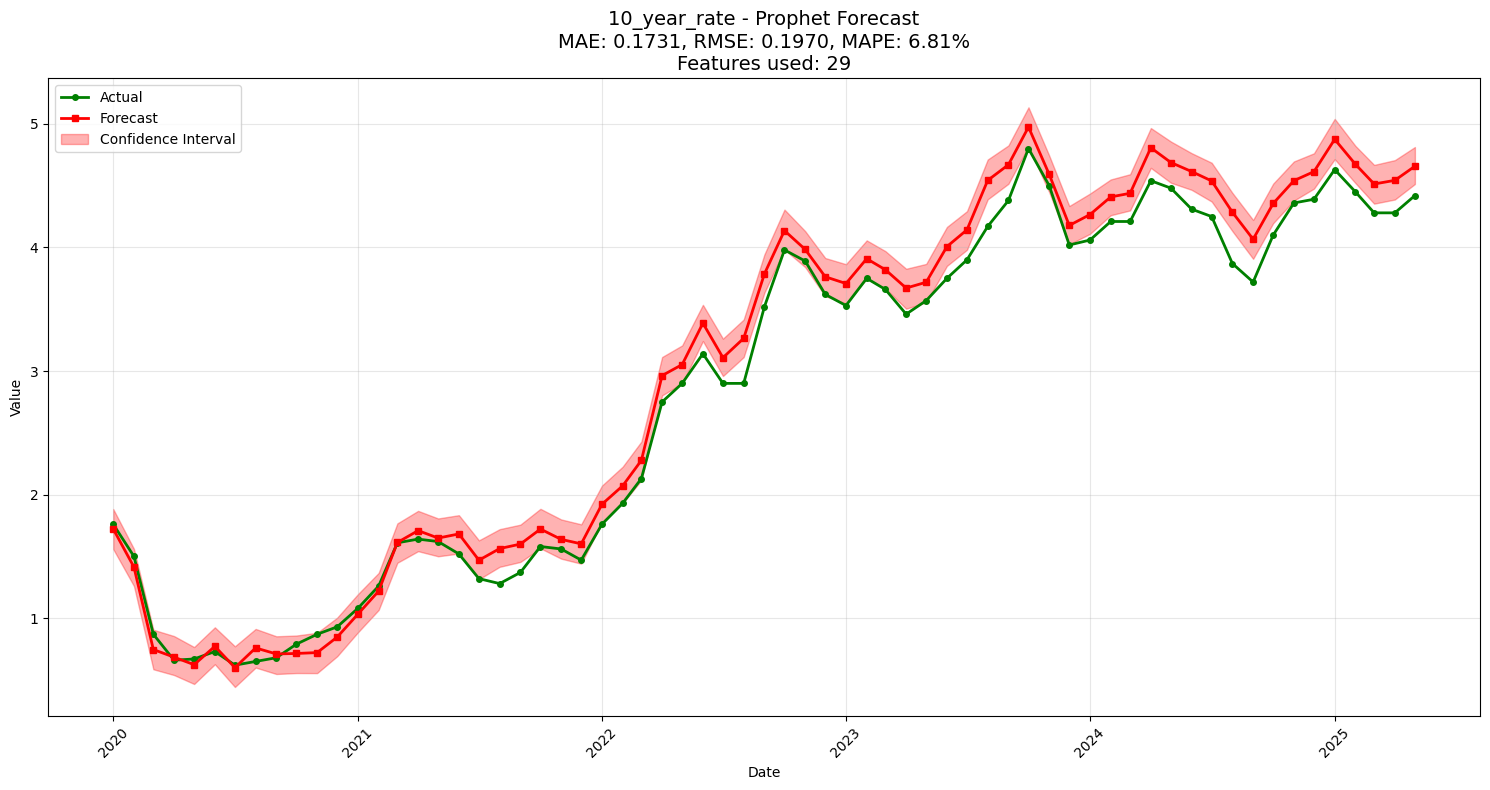

[I 2025-10-01 19:33:57,779] A new study created in memory with name: no-name-c7d32952-aff9-4c4e-a5de-431e3ca4ff11



FORECASTING: share_price
Series lengths - Train: 635, Test: 65

Preparing exogenous features for share_price...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for share_price...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


19:33:58 - cmdstanpy - INFO - Chain [1] start processing
19:33:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:33:58,788] Trial 0 finished with value: 2.9085914802177615 and parameters: {'changepoint_prior_scale': 0.04681589035861519, 'seasonality_prior_scale': 2.4566940024722164, 'holidays_prior_scale': 0.022251415268035642, 'seasonality_mode': 'additive', 'changepoint_range': 0.8545427756957381, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 0 with value: 2.9085914802177615.
19:33:59 - cmdstanpy - INFO - Chain [1] start processing
19:33:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:33:59,381] Trial 1 finished with value: 2.8177972124769313 and parameters: {'changepoint_prior_scale': 0.002911955397346315, 'seasonality_prior_scale': 0.6560250984722268, 'holidays_prior_scale': 0.24705429373726076, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9105043192525636, 'yearly_seasonality': True, 'weekly_seasonality

Best parameters: {'changepoint_prior_scale': 0.46537437358536254, 'seasonality_prior_scale': 5.561644360293199, 'holidays_prior_scale': 1.7614395491113366, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9279694211117384, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}
Best validation RMSE: 2.2984
Training final Prophet model...


19:34:42 - cmdstanpy - INFO - Chain [1] start processing
19:34:43 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 9.3624
  RMSE: 11.5519
  MAPE: 6.57%
Model saved to prophet_models/share_price_prophet_model.pkl


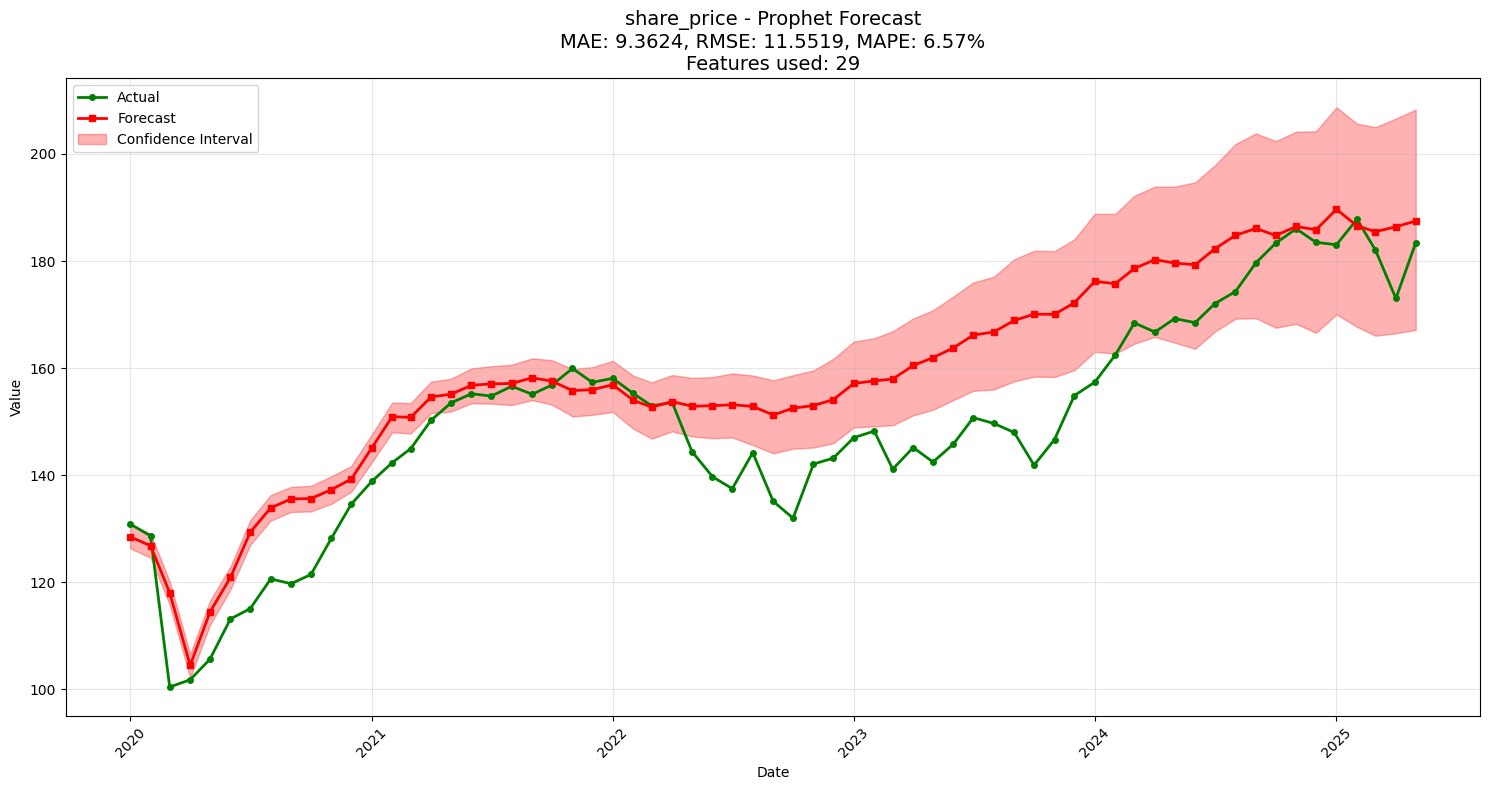

[I 2025-10-01 19:34:44,518] A new study created in memory with name: no-name-b551cb13-2e99-464e-a791-75ae456ab70a



FORECASTING: unemployment_rate
Series lengths - Train: 635, Test: 65

Preparing exogenous features for unemployment_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for unemployment_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


19:34:44 - cmdstanpy - INFO - Chain [1] start processing
19:34:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:34:45,525] Trial 0 finished with value: 0.1044944484388007 and parameters: {'changepoint_prior_scale': 0.12540338321766517, 'seasonality_prior_scale': 0.1604152154773102, 'holidays_prior_scale': 4.524946541740644, 'seasonality_mode': 'additive', 'changepoint_range': 0.9230940906596505, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.1044944484388007.
19:34:45 - cmdstanpy - INFO - Chain [1] start processing
19:34:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:34:46,238] Trial 1 finished with value: 0.09631110416453444 and parameters: {'changepoint_prior_scale': 0.019095827208569185, 'seasonality_prior_scale': 0.03785537392721891, 'holidays_prior_scale': 0.010565010002779261, 'seasonality_mode': 'additive', 'changepoint_range': 0.9292089597583104, 'yearly_seasonality': 'auto', 'weekly_seasonality': 

Best parameters: {'changepoint_prior_scale': 0.007564333326790706, 'seasonality_prior_scale': 0.011461088307686834, 'holidays_prior_scale': 0.010374997243498368, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9079940880731284, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}
Best validation RMSE: 0.0860
Training final Prophet model...


19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 2.1609
  RMSE: 2.6941
  MAPE: 41.48%
Model saved to prophet_models/unemployment_rate_prophet_model.pkl


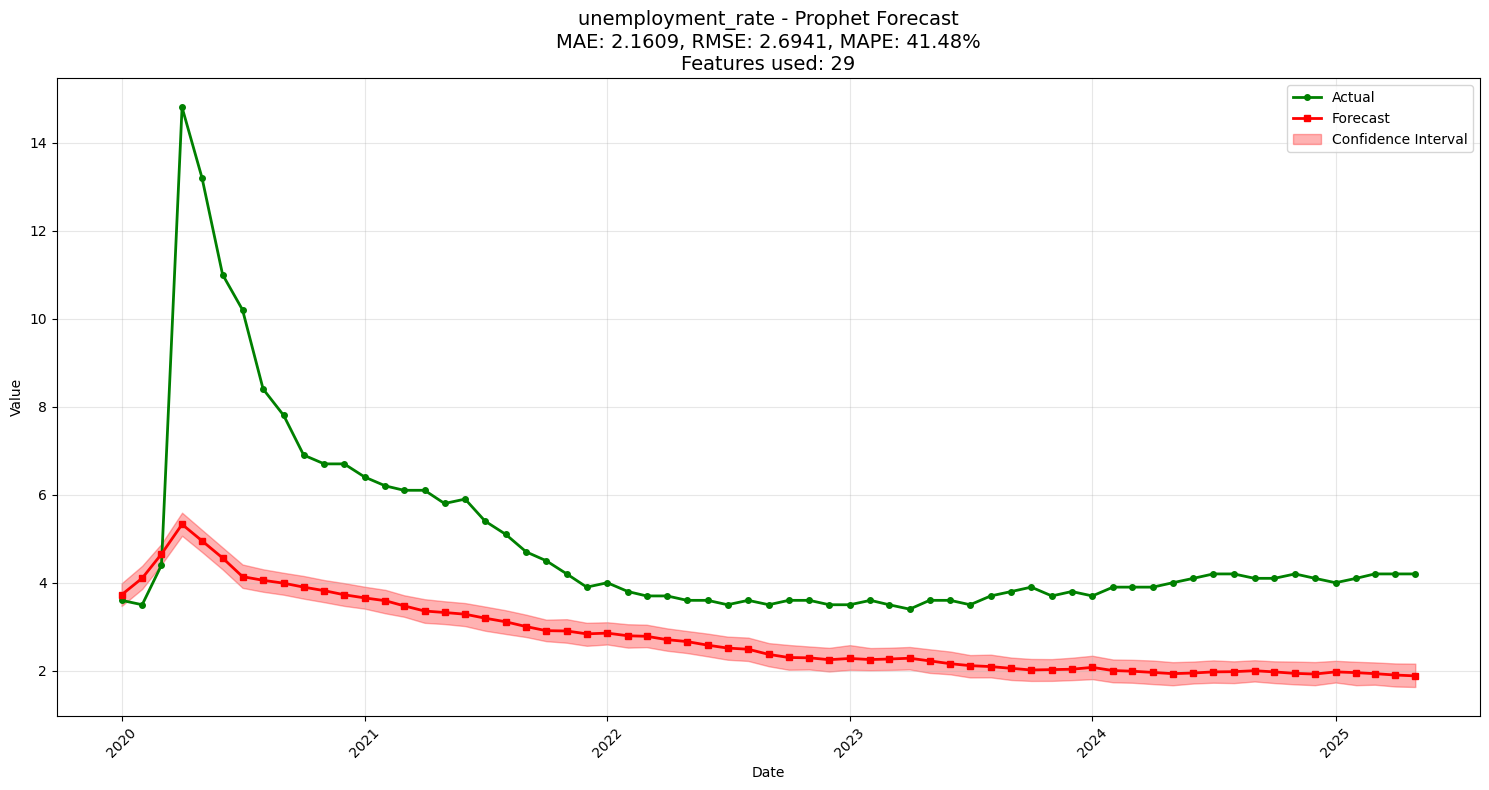

[I 2025-10-01 19:35:20,660] A new study created in memory with name: no-name-f1865053-8d2a-495d-9e9a-49d5e30028ff



FORECASTING: PPI
Series lengths - Train: 635, Test: 65

Preparing exogenous features for PPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for PPI...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


19:35:20 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:35:21,274] Trial 0 finished with value: 5.331018578694427 and parameters: {'changepoint_prior_scale': 0.003804757130839581, 'seasonality_prior_scale': 0.12223597968106105, 'holidays_prior_scale': 1.1267078085004218, 'seasonality_mode': 'additive', 'changepoint_range': 0.8289279561409364, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 0 with value: 5.331018578694427.
19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:35:22,867] Trial 1 finished with value: 4.656186336674917 and parameters: {'changepoint_prior_scale': 0.19982791283979615, 'seasonality_prior_scale': 0.014445752637238608, 'holidays_prior_scale': 3.1004488428085883, 'seasonality_mode': 'additive', 'changepoint_range': 0.8079651449372452, 'yearly_seasonality': 'auto', 'weekly_seasonality': True

Best parameters: {'changepoint_prior_scale': 0.30568334765078814, 'seasonality_prior_scale': 0.15756548050034033, 'holidays_prior_scale': 0.08493999068441851, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.865116043305588, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}
Best validation RMSE: 3.2047
Training final Prophet model...


19:35:53 - cmdstanpy - INFO - Chain [1] start processing
19:35:54 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 152.9423
  RMSE: 169.8129
  MAPE: 30.52%
Model saved to prophet_models/PPI_prophet_model.pkl


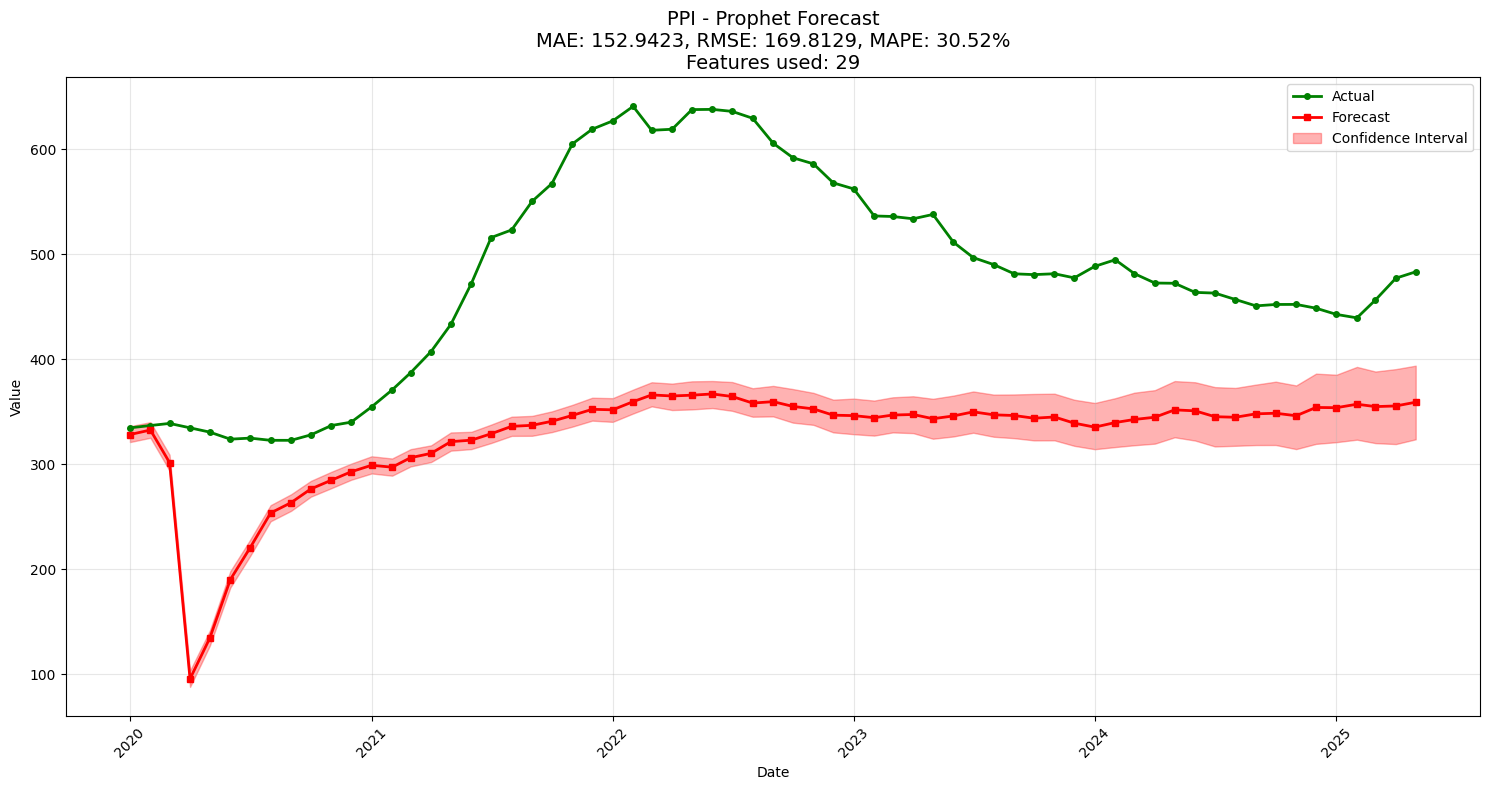

[I 2025-10-01 19:35:54,837] A new study created in memory with name: no-name-ddb38fb5-f3ce-4ae7-ba85-3b6ac8a1cca1



FORECASTING: OECD_CLI_index
Series lengths - Train: 635, Test: 65

Preparing exogenous features for OECD_CLI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'CSI_index']...
Cleaning Prophet data for OECD_CLI_index...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


19:35:55 - cmdstanpy - INFO - Chain [1] start processing
19:35:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:35:55,876] Trial 0 finished with value: 0.04496041442964326 and parameters: {'changepoint_prior_scale': 0.3175655845912357, 'seasonality_prior_scale': 0.044235375355328406, 'holidays_prior_scale': 0.1105260542911729, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8768257703805693, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.04496041442964326.
19:35:56 - cmdstanpy - INFO - Chain [1] start processing
19:35:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:35:58,059] Trial 1 finished with value: 0.056922492768383535 and parameters: {'changepoint_prior_scale': 0.01817627684356532, 'seasonality_prior_scale': 0.04051307193406696, 'holidays_prior_scale': 0.8742990752158488, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8805100293216823, 'yearly_seasonality': True, 'weekly_se

Best parameters: {'changepoint_prior_scale': 0.09986142804141059, 'seasonality_prior_scale': 9.251198798629666, 'holidays_prior_scale': 0.010583861051669542, 'seasonality_mode': 'additive', 'changepoint_range': 0.8365966289805418, 'yearly_seasonality': False, 'weekly_seasonality': True}
Best validation RMSE: 0.0423
Training final Prophet model...


19:36:34 - cmdstanpy - INFO - Chain [1] start processing
19:36:35 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 0.3416
  RMSE: 0.4027
  MAPE: 0.34%
Model saved to prophet_models/OECD_CLI_index_prophet_model.pkl


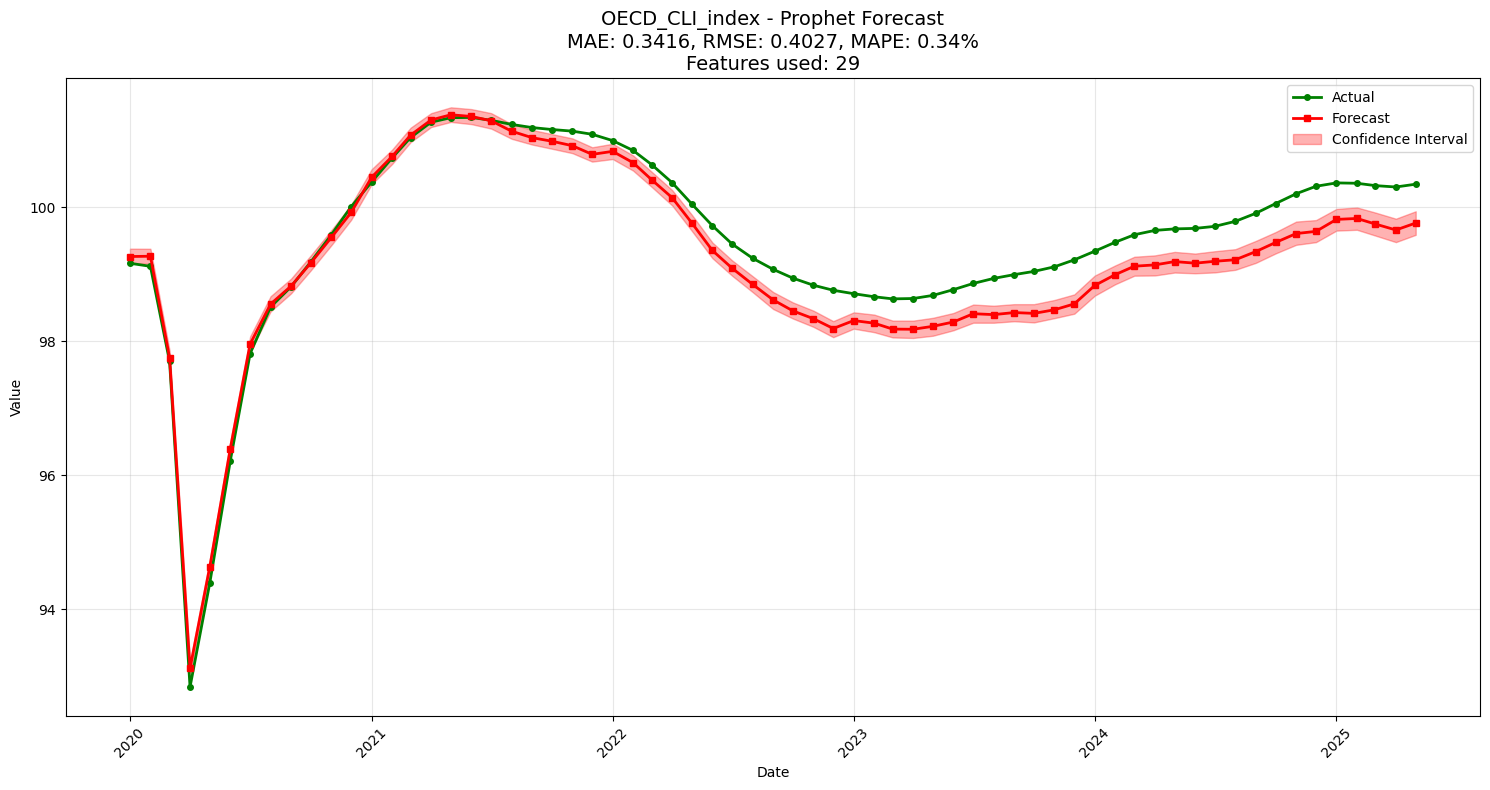

[I 2025-10-01 19:36:35,654] A new study created in memory with name: no-name-fb1787ef-2b7c-4708-b172-fc7431281f0e



FORECASTING: CSI_index
Series lengths - Train: 635, Test: 65

Preparing exogenous features for CSI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning Prophet data for CSI_index...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


19:36:35 - cmdstanpy - INFO - Chain [1] start processing
19:36:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:36:36,409] Trial 0 finished with value: 2.364564611506215 and parameters: {'changepoint_prior_scale': 0.006214170196937825, 'seasonality_prior_scale': 3.9575686734274877, 'holidays_prior_scale': 0.7293975369820741, 'seasonality_mode': 'additive', 'changepoint_range': 0.8024092108725677, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 0 with value: 2.364564611506215.
19:36:36 - cmdstanpy - INFO - Chain [1] start processing
19:36:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:36:37,023] Trial 1 finished with value: 2.587034117713988 and parameters: {'changepoint_prior_scale': 0.013946901802702482, 'seasonality_prior_scale': 6.308086760814623, 'holidays_prior_scale': 0.01112099737759025, 'seasonality_mode': 'additive', 'changepoint_range': 0.8816227115361299, 'yearly_seasonality': False, 'weekly_seasonality': False}.

Best parameters: {'changepoint_prior_scale': 0.11204642334599764, 'seasonality_prior_scale': 0.17296100509814397, 'holidays_prior_scale': 0.12547713260506954, 'seasonality_mode': 'additive', 'changepoint_range': 0.8314739190954801, 'yearly_seasonality': False, 'weekly_seasonality': True}
Best validation RMSE: 2.2594
Training final Prophet model...


19:36:55 - cmdstanpy - INFO - Chain [1] start processing
19:36:55 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 13.9491
  RMSE: 16.1660
  MAPE: 20.86%
Model saved to prophet_models/CSI_index_prophet_model.pkl


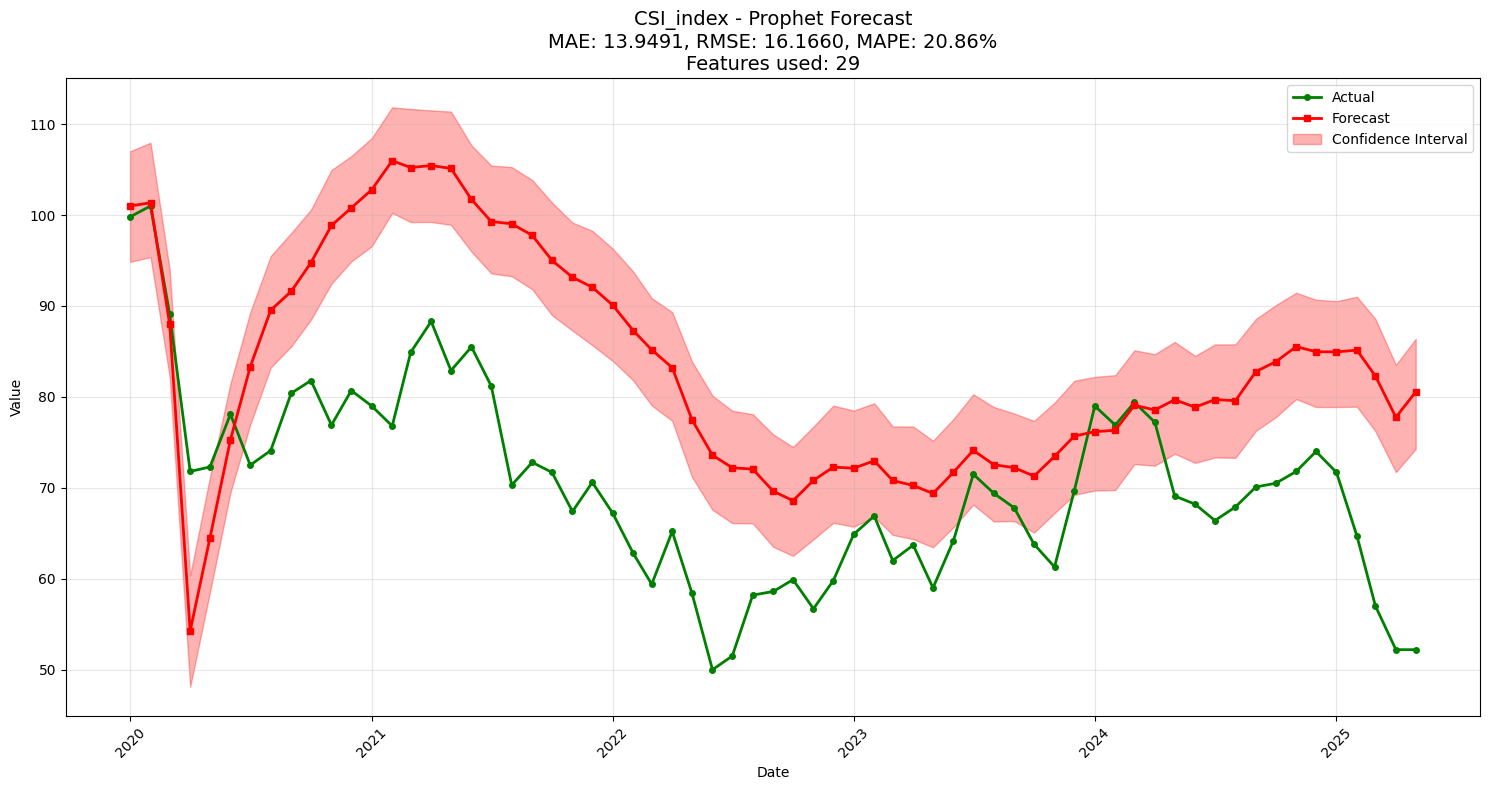

[I 2025-10-01 19:36:56,627] A new study created in memory with name: no-name-c51034df-99da-4820-a354-f88784101519



FORECASTING: gdp_per_capita
Series lengths - Train: 635, Test: 64

Preparing exogenous features for gdp_per_capita...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning Prophet data for gdp_per_capita...
  Train shape: (635, 31), Test shape: (64, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (64, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


19:36:57 - cmdstanpy - INFO - Chain [1] start processing
19:36:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:36:59,053] Trial 0 finished with value: 70.78780920239043 and parameters: {'changepoint_prior_scale': 0.0018145521232102494, 'seasonality_prior_scale': 0.5441928942115496, 'holidays_prior_scale': 9.86858471817626, 'seasonality_mode': 'additive', 'changepoint_range': 0.8055653011940591, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 0 with value: 70.78780920239043.
19:36:59 - cmdstanpy - INFO - Chain [1] start processing
19:37:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-10-01 19:37:01,242] Trial 1 finished with value: 101.45164405076765 and parameters: {'changepoint_prior_scale': 0.01634124685363137, 'seasonality_prior_scale': 2.1155759062549078, 'holidays_prior_scale': 0.3544760384104682, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.915847894395249, 'yearly_seasonality': False, 'weekly_seasonality': True

Best parameters: {'changepoint_prior_scale': 0.08378814491902534, 'seasonality_prior_scale': 0.010321655352454792, 'holidays_prior_scale': 0.011904036971033734, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8844253649718312, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}
Best validation RMSE: 65.0636
Training final Prophet model...


19:38:02 - cmdstanpy - INFO - Chain [1] start processing
19:38:04 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 259.2715
  RMSE: 298.9386
  MAPE: 0.39%
Model saved to prophet_models/gdp_per_capita_prophet_model.pkl


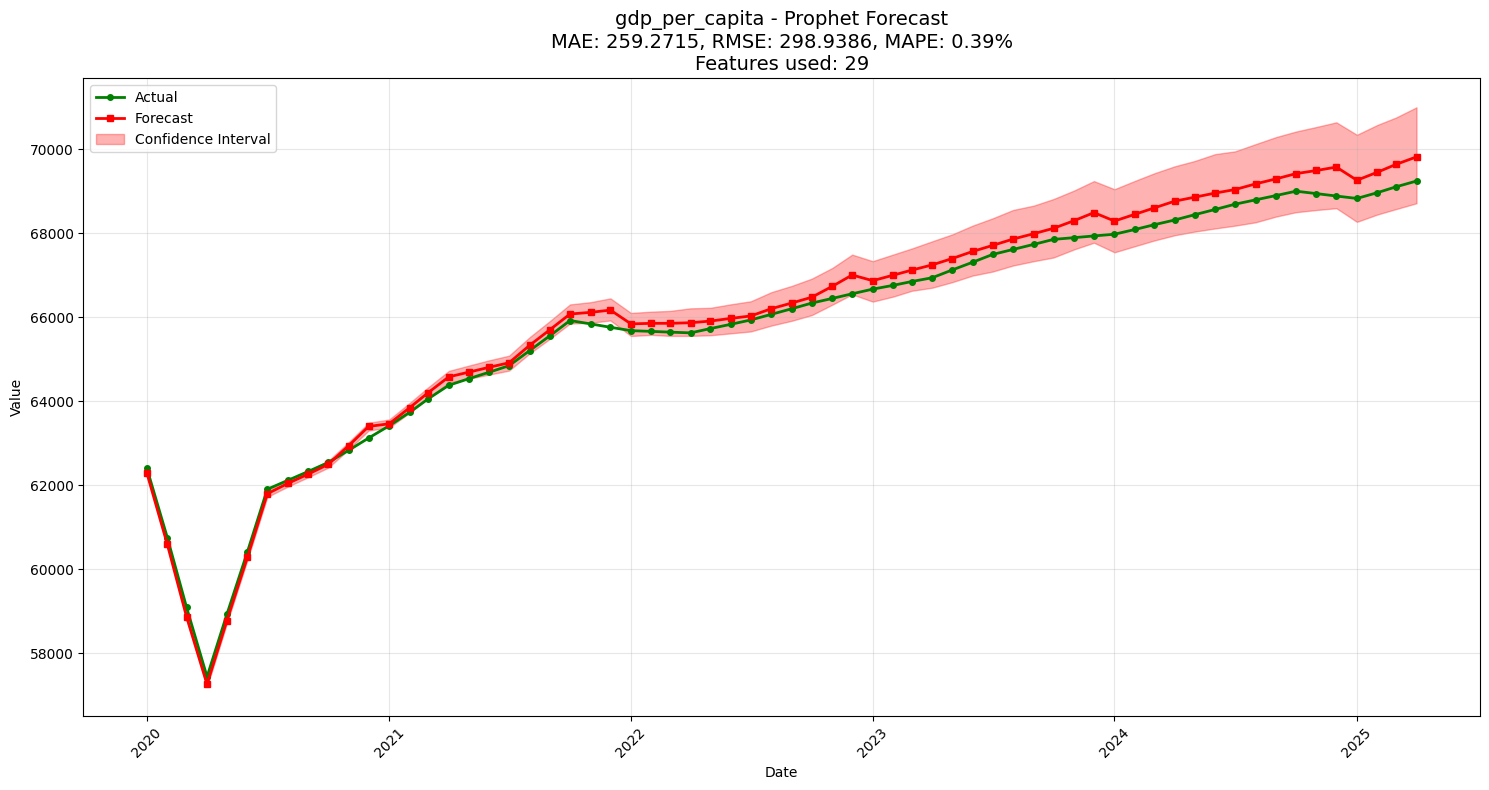


PROPHET FORECASTING COMPLETE
Successfully forecasted 12 indicators

SUMMARY METRICS:
1_year_rate          - MAE: 0.1777, RMSE: 0.2066, MAPE: 22.54% (Features: 29)
3_months_rate        - MAE: 0.2478, RMSE: 0.2689, MAPE: 105.22% (Features: 29)
6_months_rate        - MAE: 0.0961, RMSE: 0.1102, MAPE: 30.80% (Features: 29)
CPI                  - MAE: 27.2472, RMSE: 33.8022, MAPE: 8.91% (Features: 29)
INDPRO               - MAE: 6.0030, RMSE: 6.6032, MAPE: 5.88% (Features: 29)
10_year_rate         - MAE: 0.1731, RMSE: 0.1970, MAPE: 6.81% (Features: 29)
share_price          - MAE: 9.3624, RMSE: 11.5519, MAPE: 6.57% (Features: 29)
unemployment_rate    - MAE: 2.1609, RMSE: 2.6941, MAPE: 41.48% (Features: 29)
PPI                  - MAE: 152.9423, RMSE: 169.8129, MAPE: 30.52% (Features: 29)
OECD_CLI_index       - MAE: 0.3416, RMSE: 0.4027, MAPE: 0.34% (Features: 29)
CSI_index            - MAE: 13.9491, RMSE: 16.1660, MAPE: 20.86% (Features: 29)
gdp_per_capita       - MAE: 259.2715, RMSE: 298.938

In [3]:
# Main forecasting function (same interface as XGBoost)
all_results, forecasted = run_prophet_forecasting_with_exogenous(
    train_df, test_df, 
    financial_indicators=financial_indicators,
    n_trials=30,  # Prophet is slower, so fewer trials
    plot_results=True
)

# # Quick test without hyperparameter optimization
# model, forecast, actual, predicted = prophet_quick_forecast(
#     train_df, test_df, '1_year_rate', 
#     exog_features=['3_months_rate', 'CPI', 'unemployment_rate']
# )